#Stage Four - Modelling
#What Makes a Painting Display-Worthy at the Met Museum?
#Predicting the likelihood of gallery display at The Metropolitan Museum of Art
This notebook builds a classification model to predict whether a painting is on display or in storage.
Starting with a decision tree, which is a model that makes predictions by asking a series of yes/no questions about the data. It is easy to visualise and explain.
Will then try a logistic regression, which estimates the probability of display by fitting a single equation and produces odds ratios showing how each feature pushes the probability up or down.
Will then try a random forest, which is an ensemble method covered in the course. It works by building many decision trees, each trained on a different subset of data and features, and combining their predictions. Hyperparameters are tuned using GridSearchCV to find the best configuration.
Finally, will try gradient boosting, another ensemble method which builds trees sequentially, with each tree correcting the errors of the previous one.
All five models; decision tree, logistic regression, random forest, tuned random forest, and gradient boosting will then be compared on accuracy, precision, recall, and F1 score. Before making a final decision on what is best.

#Stage One - setup

In [1]:
import os
os.chdir("/Users/rosswilson/Projects/ironhack/Final Project")
print("Working directory:", os.getcwd())

Working directory: /Users/rosswilson/Projects/ironhack/Final Project


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
os.makedirs("images", exist_ok=True)

df = pd.read_csv("data/clean/met_paintings_clean.csv")
print(f"Loaded: {len(df):,} rows x {df.shape[1]} columns")
print(f"Display rate: {df['is_on_display'].mean()*100:.1f}%")

Loaded: 9,005 rows x 40 columns
Display rate: 15.3%


#Stage Two - preparing features for modelling

Need to encode categorical features and check for any duplicate columns before feeding the data into a model.

In [3]:
#Checking for duplicate columns (eg tag_count appeared twice in EDA)
dupes = df.columns[df.columns.duplicated()].tolist()
if dupes:
    print(f"Duplicate columns found: {dupes}")
    df = df.loc[:, ~df.columns.duplicated()]
    print(f"Removed duplicates. Columns now: {df.shape[1]}")
else:
    print("No duplicate columns.")

No duplicate columns.


In [4]:
# Defining feature columns
tag_cols = [c for c in df.columns if c.startswith("tag_")]

numeric_features = [
    "painting_age", "creation_year",
    "height_cm", "width_cm", "area_cm2",
    "log_area_cm2", "log_height_cm", "log_width_cm",
    "aspect_ratio",
    "accession_year", "years_in_collection",
    "artist_work_count", "tag_count",
    "is_public_domain", "is_highlight", "has_known_artist",
    "is_portrait_orientation", "recently_acquired",
    "accession_year_unknown", "is_collaborative_work",
    "object_begin_date", "object_end_date"
] + tag_cols

# Note: gallery_number is intentionally excluded -- it was used to derive
# is_on_display so including it would be data leakage
# is_highlight is included but flagged for careful interpretation --
# it may partly reflect the same curatorial judgement as display status
categorical_features = [
    "department", "primary_medium", "support",
    "nationality_group", "acquisition_type",
    "era", "culture_group"
]

# Only keep columns that actually exist in the dataframe
numeric_features = [c for c in numeric_features if c in df.columns]
categorical_features = [c for c in categorical_features if c in df.columns]

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Numeric features list: {numeric_features}")
print(f"Categorical features list: {categorical_features}")

Numeric features: 26
Categorical features: 5
Numeric features list: ['painting_age', 'creation_year', 'height_cm', 'width_cm', 'area_cm2', 'accession_year', 'years_in_collection', 'artist_work_count', 'tag_count', 'is_public_domain', 'is_highlight', 'has_known_artist', 'object_begin_date', 'object_end_date', 'tag_count', 'tag_men', 'tag_women', 'tag_landscapes', 'tag_portraits', 'tag_mountains', 'tag_trees', 'tag_flowers', 'tag_birds', 'tag_horses', 'tag_abstraction', 'tag_count.1']
Categorical features list: ['department', 'primary_medium', 'support', 'nationality_group', 'acquisition_type']


#Stage Two - Part Two: encoding categorical features

Decision trees and random forests can handle encoded categories directly.
Can use label encoding here since tree-based models work well with it.

In [5]:
#Labelling encode categorical features
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df[col + "_encoded"] = le.fit_transform(df[col].fillna("Unknown").astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} categories")

encoded_features = [col + "_encoded" for col in categorical_features]
all_features = numeric_features + encoded_features

print(f"\nTotal features for modelling is: {len(all_features)}")

department: 11 categories
primary_medium: 11 categories
support: 9 categories
nationality_group: 17 categories
acquisition_type: 5 categories

Total features for modelling is: 31


#Stage Three - train and test split

Decided to use a stratified split to make sure the display rate is the same in training and test sets. This is important because only about 15% of paintings are on display according to data.

In [6]:
X = df[all_features]
y = df["is_on_display"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} rows")
print(f"Test set:     {len(X_test):,} rows")
print(f"\nTraining display rate: {y_train.mean()*100:.1f}%")
print(f"Test display rate:     {y_test.mean()*100:.1f}%")

Training set: 7,204 rows
Test set:     1,801 rows

Training display rate: 15.3%
Test display rate:     15.3%


#Stage Four - baseline model

Before building any model, need to establish a baseline to compare against. The simplest baseline is to predict that every painting is not on display, since that is the majority class.

In [7]:
# Baseline: predicting everything as not displayed
baseline_accuracy = 1 - y_test.mean()
print(f"Baseline accuracy (predict all as not displayed): {baseline_accuracy*100:.1f}%")
print("\nAny model built needs to beat this to be useful.")

Baseline accuracy (predict all as not displayed): 84.7%

Any model built needs to beat this to be useful.


#Stage Four - Part Two: univariate statistical tests on numeric features

Before building any model it is worth testing whether the patterns from notebook three are statistically significant or could just be down to chance.

Point-biserial correlation is a version of Pearson correlation used when one variable is binary like displayed or not. It gives both a correlation coefficient and a p-value.

A p-value below 0.05 means there is less than a 5% chance the relationship is due to random chance alone.

In [8]:
from scipy import stats

# Pearson (point-biserial) correlation for numeric features against display status
numeric_test_cols = [
    "painting_age", "years_in_collection", "area_cm2", "log_area_cm2",
    "aspect_ratio", "height_cm", "width_cm",
    "artist_work_count", "tag_count",
    "is_public_domain", "is_highlight", "has_known_artist",
    "is_portrait_orientation", "recently_acquired",
    "accession_year_unknown", "is_collaborative_work"
]

# Only test columns that exist
numeric_test_cols = [c for c in numeric_test_cols if c in df.columns]

pearson_results = []
for col in numeric_test_cols:
    corr, p_value = stats.pointbiserialr(df["is_on_display"], df[col])
    pearson_results.append({
        "feature": col,
        "pearson_r": round(corr, 4),
        "p_value": p_value,
        "significant": "yes" if p_value < 0.05 else "no"
    })

pearson_df = pd.DataFrame(pearson_results).sort_values("pearson_r", ascending=False)
print("Pearson correlation with is_on_display:")
print(pearson_df.to_string(index=False))

Pearson correlation with is_on_display:
            feature  pearson_r       p_value significant
          tag_count     0.3207 1.516142e-214         yes
   is_public_domain     0.2421 3.066144e-120         yes
       is_highlight     0.2084  6.233612e-89         yes
   has_known_artist     0.1583  1.340923e-51         yes
       painting_age     0.1234  6.832092e-32         yes
years_in_collection     0.1087  4.257583e-25         yes
          height_cm     0.0620  3.930943e-09         yes
           area_cm2     0.0310  3.307562e-03         yes
           width_cm    -0.0029  7.798702e-01          no
  artist_work_count    -0.0727  5.100020e-12         yes


#Stage Four - Part Three: Spearman correlation

Pearson measures linear relationships. Spearman measures monotonic relationships, meaning it can pick up patterns where one variable increases as the other increases but not necessarily in a straight line. Comparing the two shows where the relationship might be curved rather than straight.

In [9]:
spearman_results = []
for col in numeric_test_cols:
    corr, p_value = stats.spearmanr(df["is_on_display"], df[col])
    spearman_results.append({
        "feature": col,
        "spearman_r": round(corr, 4),
        "p_value": p_value,
        "significant": "yes" if p_value < 0.05 else "no"
    })

spearman_df = pd.DataFrame(spearman_results).sort_values("spearman_r", ascending=False)
print("Spearman correlation with is_on_display:")
print(spearman_df.to_string(index=False))

Spearman correlation with is_on_display:
            feature  spearman_r       p_value significant
          tag_count      0.3099 1.049917e-199         yes
   is_public_domain      0.2421 3.066144e-120         yes
       is_highlight      0.2084  6.233612e-89         yes
       painting_age      0.1930  2.470673e-76         yes
   has_known_artist      0.1583  1.340923e-51         yes
  artist_work_count      0.1473  7.284605e-45         yes
years_in_collection      0.1084  5.923438e-25         yes
           area_cm2      0.0884  4.315843e-17         yes
           width_cm      0.0853  5.249313e-16         yes
          height_cm      0.0838  1.712822e-15         yes


In [10]:
#Comparing Pearson and Spearman side by side
comparison = pearson_df[["feature", "pearson_r"]].merge(
    spearman_df[["feature", "spearman_r"]], on="feature"
)
comparison["difference"] = (comparison["spearman_r"] - comparison["pearson_r"]).round(4)
print("Pearson vs Spearman comparison:")
print("(Large differences suggest a non-linear relationship)")
print(comparison.sort_values("difference", ascending=False).to_string(index=False))

Pearson vs Spearman comparison:
(Large differences suggest a non-linear relationship)
            feature  pearson_r  spearman_r  difference
  artist_work_count    -0.0727      0.1473      0.2200
           width_cm    -0.0029      0.0853      0.0882
       painting_age     0.1234      0.1930      0.0696
           area_cm2     0.0310      0.0884      0.0574
          height_cm     0.0620      0.0838      0.0218
   is_public_domain     0.2421      0.2421      0.0000
       is_highlight     0.2084      0.2084      0.0000
   has_known_artist     0.1583      0.1583      0.0000
years_in_collection     0.1087      0.1084     -0.0003
          tag_count     0.3207      0.3099     -0.0108


#Stage Four - Part Four: chi-squared tests on categorical features

For categorical features a chi-squared test of independence checks whether the distribution of displayed versus stored paintings differs significantly across categories.

Cramer's V measures the strength of that association on a 0 to 1 scale where 0 means no relationship and 1 means a perfect one.

In [11]:
chi2_results = []

# categorical_features now includes era and culture_group from notebook two
for col in categorical_features:
    contingency = pd.crosstab(df[col], df["is_on_display"])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    n = contingency.sum().sum()
    min_dim = min(contingency.shape[0] - 1, contingency.shape[1] - 1)
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
    
    chi2_results.append({
        "feature": col,
        "chi2": round(chi2, 2),
        "p_value": p_value,
        "degrees_of_freedom": dof,
        "cramers_v": round(cramers_v, 4),
        "significant": "yes" if p_value < 0.05 else "no"
    })

chi2_df = pd.DataFrame(chi2_results).sort_values("cramers_v", ascending=False)
print("Chi-squared test results:")
print(chi2_df.to_string(index=False))

Chi-squared test results:
          feature    chi2       p_value  degrees_of_freedom  cramers_v significant
       department 2912.94  0.000000e+00                  10     0.5688         yes
nationality_group 2316.79  0.000000e+00                  16     0.5072         yes
   primary_medium 1462.05 3.957359e-308                  10     0.4029         yes
          support 1403.41 1.037356e-297                   8     0.3948         yes
 acquisition_type  595.36 1.562796e-127                   4     0.2571         yes


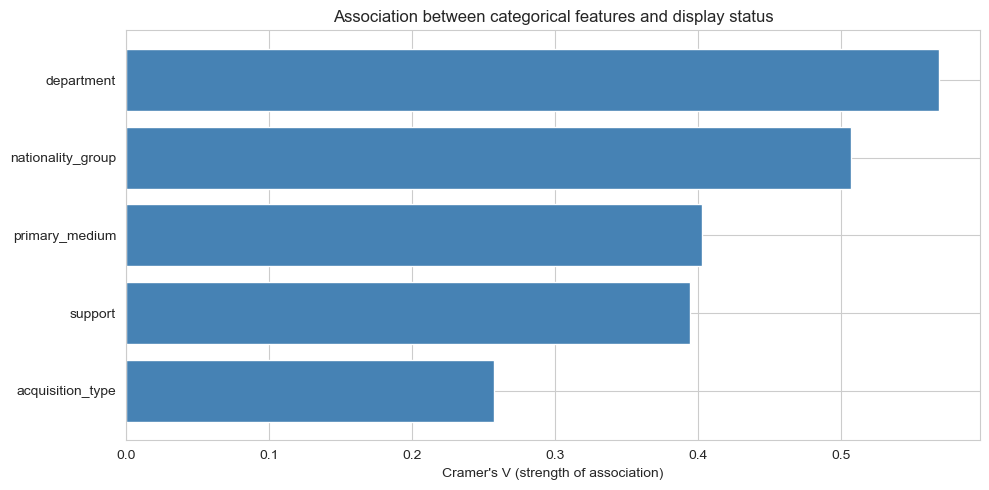

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(chi2_df["feature"], chi2_df["cramers_v"], color="steelblue")
ax.set_xlabel("Cramer's V (strength of association)")
ax.set_title("Association between categorical features and display status")
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("images/cramers_v.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Four - Part Five: Mann-Whitney U tests

Comparing the median values of each numeric feature between displayed and stored paintings. The Mann-Whitney U test checks whether the difference in medians is statistically significant without assuming any particular shape of relationship.

In [13]:
displayed = df[df["is_on_display"] == 1]
stored = df[df["is_on_display"] == 0]

mann_whitney_results = []
for col in numeric_test_cols:
    stat, p_value = stats.mannwhitneyu(
        displayed[col], stored[col], alternative="two-sided"
    )
    mann_whitney_results.append({
        "feature": col,
        "median_displayed": round(displayed[col].median(), 2),
        "median_stored": round(stored[col].median(), 2),
        "p_value": p_value,
        "significant": "yes" if p_value < 0.05 else "no"
    })

mw_df = pd.DataFrame(mann_whitney_results).sort_values("p_value")
print("Mann-Whitney U test results (displayed versus stored):")
print(mw_df.to_string(index=False))

Mann-Whitney U test results (displayed versus stored):
            feature  median_displayed  median_stored       p_value significant
          tag_count               3.0           2.00 4.368789e-190         yes
   is_public_domain               1.0           1.00 9.280916e-117         yes
       is_highlight               0.0           0.00  4.836955e-87         yes
       painting_age             297.0         181.00  5.982022e-75         yes
   has_known_artist               1.0           1.00  5.569055e-51         yes
  artist_work_count               4.0           2.00  2.112364e-44         yes
years_in_collection              59.0          44.00  8.055295e-25         yes
           area_cm2            4838.7        3291.84  4.935569e-17         yes
           width_cm              65.1          51.50  5.894157e-16         yes
          height_cm              69.2          60.96  1.907535e-15         yes


#Stage Four - Part Six: summary of statistical tests

1.Every single numeric feature except width_cm showed a statistically significant relationship with display status under Pearson correlation. tag_count had the strongest correlation at 0.32, followed by is_public_domain at 0.24 and is_highlight at 0.21. These are not huge correlations but they are all highly significant with p-values effectively at zero.

2.The biggest difference between Pearson and Spearman was artist_work_count. Pearson gave it a negative correlation of -0.07 but Spearman gave it a positive 0.15. This means the relationship is non-linear, probably because a handful of artists with very high work counts like Xie Zhiliu with 344 paintings are dragging the linear correlation down even though in general having more works in the collection is associated with display.

3.width_cm was the only feature not significant under Pearson but it was significant under Spearman, again suggesting a non-linear relationship with display.

4.For categorical features department had the strongest association with display at a Cramer's V of 0.57, followed closely by nationality_group at 0.51. This confirms what the EDA showed, that which department a painting belongs to is the single biggest factor in whether it gets displayed.

5.The Mann-Whitney tests showed that displayed paintings are older (median age 298 vs 181), larger (median area 4839 vs 3434 cm2), have been in the collection longer (59 vs 44 years), and have more tags (3 vs 2). All differences were statistically significant. This gives confidence that these are real patterns not just noise.

6.All five categorical features were significant at p < 0.05 in the chi-squared tests, so none need to be excluded from the model on statistical grounds.

#Stage Five - decision tree classifier

Start with a decision tree because it is easy to interpret and visualise. This makes it a good model for presenting findings at the Hackshow.

Then use class_weight='balanced' to handle the imbalanced classes, so the model does not just learn to predict everything as not displayed.

In [14]:
#Training the decision tree with balanced class weights
dt = DecisionTreeClassifier(
    max_depth=5,
    class_weight="balanced",
    random_state=42
)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision tree results")
print(f"Accuracy is:  {accuracy_score(y_test, y_pred_dt)*100:.1f}%")
print(f"Precision is: {precision_score(y_test, y_pred_dt)*100:.1f}%")
print(f"Recall is:    {recall_score(y_test, y_pred_dt)*100:.1f}%")
print(f"F1 score is:  {f1_score(y_test, y_pred_dt)*100:.1f}%")

Decision tree results
Accuracy is:  84.2%
Precision is: 49.2%
Recall is:    88.4%
F1 score is:  63.2%


In [15]:
print(classification_report(y_test, y_pred_dt, target_names=["In storage", "On display"]))

              precision    recall  f1-score   support

  In storage       0.98      0.83      0.90      1525
  On display       0.49      0.88      0.63       276

    accuracy                           0.84      1801
   macro avg       0.73      0.86      0.77      1801
weighted avg       0.90      0.84      0.86      1801



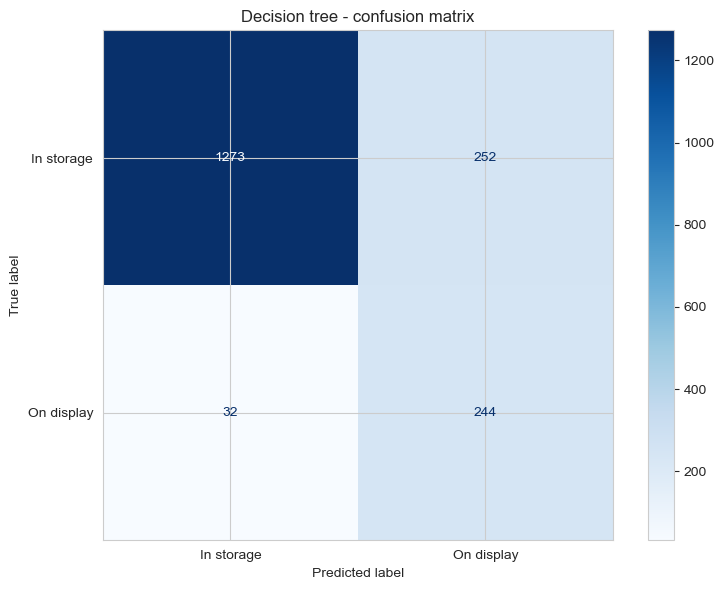

In [16]:
#Running the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_dt,
    display_labels=["In storage", "On display"],
    cmap="Blues",
    ax=ax
)
ax.set_title("Decision tree - confusion matrix")
plt.tight_layout()
plt.savefig("images/dt_confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Five - Part Two: visualising the decision tree

One of the big advantages of a decision tree is that it's easier to actually see how it makes decisions.

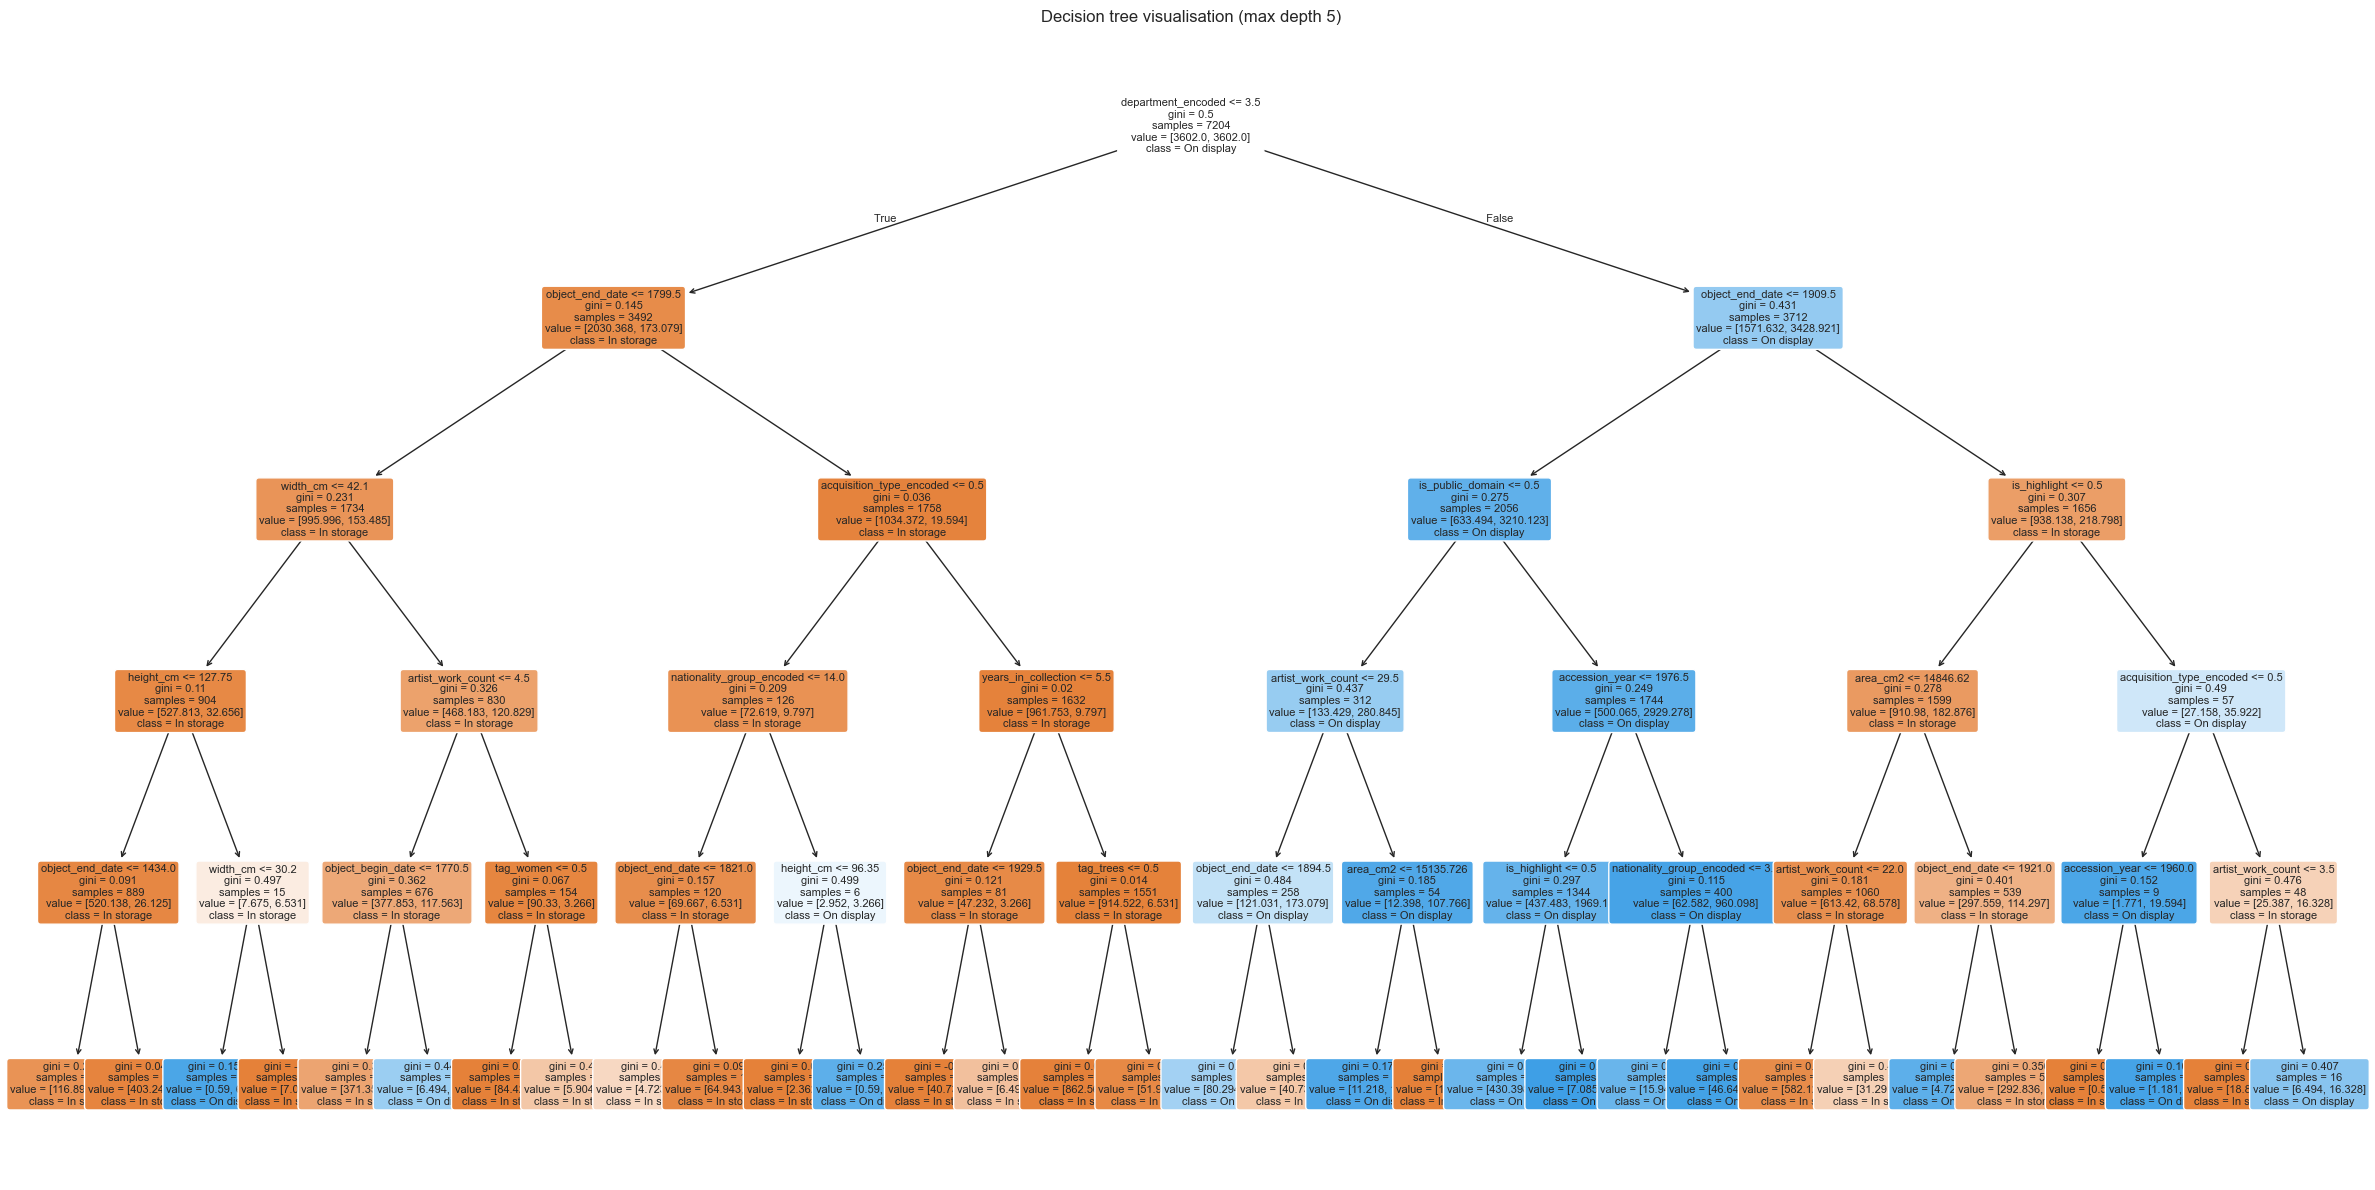

In [17]:
fig, ax = plt.subplots(figsize=(24, 12))
plot_tree(
    dt,
    feature_names=all_features,
    class_names=["In storage", "On display"],
    filled=True,
    rounded=True,
    fontsize=8,
    ax=ax
)
ax.set_title("Decision tree visualisation (max depth 5)")
plt.tight_layout()
plt.savefig("images/decision_tree.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Five - Part Three: feature importances from the decision tree

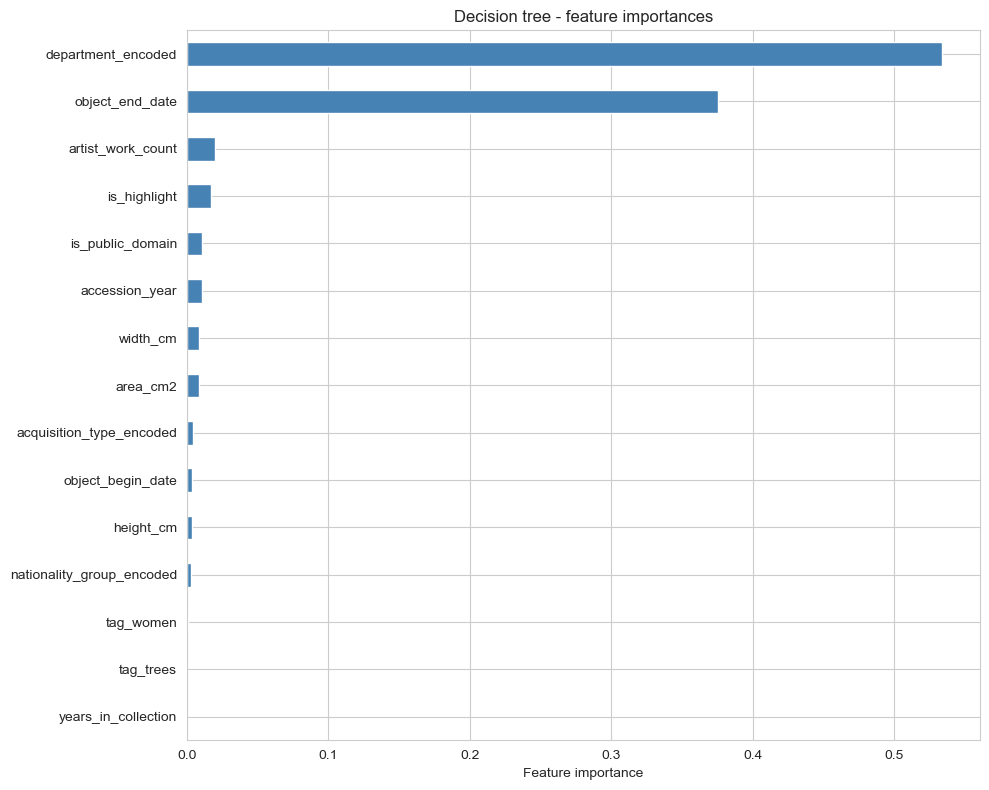

In [18]:
dt_importances = pd.Series(dt.feature_importances_, index=all_features)
dt_importances = dt_importances.sort_values(ascending=True)

#Showing only features with non-zero importance
dt_importances_nz = dt_importances[dt_importances > 0]

fig, ax = plt.subplots(figsize=(10, 8))
dt_importances_nz.plot(kind="barh", ax=ax, color="steelblue")
ax.set_xlabel("Feature importance")
ax.set_title("Decision tree - feature importances")
plt.tight_layout()
plt.savefig("images/dt_feature_importances.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Six - logistic regression

Logistic regression predicts the probability that a painting is on display. Unlike the decision tree which splits data into groups, logistic regression fits a single equation that estimates how each feature pushes the probability up or down.

The key output is odds ratios. An odds ratio of 2.0 for a feature means paintings with that characteristic are twice as likely to be on display. An odds ratio below 1.0 means they are less likely.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scaling features so the coefficients are comparable
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Results")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr)*100:.1f}%")
print(f"Precision: {precision_score(y_test, y_pred_lr)*100:.1f}%")
print(f"Recall:    {recall_score(y_test, y_pred_lr)*100:.1f}%")
print(f"F1 Score:  {f1_score(y_test, y_pred_lr)*100:.1f}%")

Logistic Regression Results
Accuracy:  81.6%
Precision: 44.6%
Recall:    83.0%
F1 Score:  58.0%


In [20]:
print(classification_report(y_test, y_pred_lr, target_names=["In storage", "On display"]))

              precision    recall  f1-score   support

  In storage       0.96      0.81      0.88      1525
  On display       0.45      0.83      0.58       276

    accuracy                           0.82      1801
   macro avg       0.70      0.82      0.73      1801
weighted avg       0.88      0.82      0.84      1801



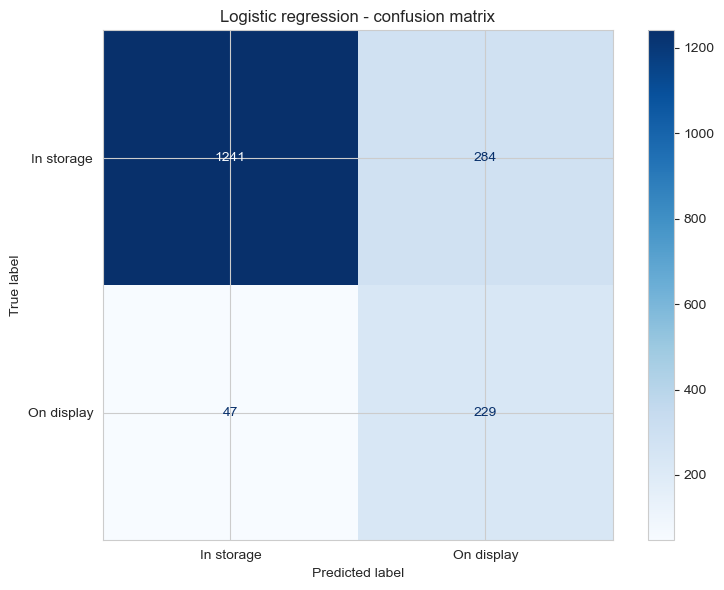

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr,
    display_labels=["In storage", "On display"],
    cmap="Blues",
    ax=ax
)
ax.set_title("Logistic regression - confusion matrix")
plt.tight_layout()
plt.savefig("images/lr_confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Six - Part Two: calculating odds ratios with 95% confidence intervals

Converting the logistic regression coefficients into odds ratios. The confidence intervals are calculated using bootstrap resampling. If a confidence interval does not cross 1.0 then the feature has a statistically significant effect on display status.

In [22]:
from sklearn.utils import resample

coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": lr.coef_[0],
    "odds_ratio": np.exp(lr.coef_[0])
})

# Bootstrapping confidence intervals
n_bootstrap = 100
boot_coefs = []

for i in range(n_bootstrap):
    X_boot, y_boot = resample(X_train_scaled, y_train, random_state=i)
    lr_boot = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
    lr_boot.fit(X_boot, y_boot)
    boot_coefs.append(lr_boot.coef_[0])

boot_coefs = np.array(boot_coefs)
ci_lower = np.exp(np.percentile(boot_coefs, 2.5, axis=0))
ci_upper = np.exp(np.percentile(boot_coefs, 97.5, axis=0))

coef_df["ci_lower"] = ci_lower
coef_df["ci_upper"] = ci_upper
coef_df["significant"] = ~((coef_df["ci_lower"] <= 1) & (coef_df["ci_upper"] >= 1))

coef_df = coef_df.sort_values("odds_ratio", ascending=False)

print("Top 15 features by odds ratio (significant only):")
print(coef_df[coef_df["significant"]][["feature", "odds_ratio", "ci_lower", "ci_upper"]].head(15).to_string(index=False))

print("\nBottom 10 features by odds ratio (significant only):")
print(coef_df[coef_df["significant"]][["feature", "odds_ratio", "ci_lower", "ci_upper"]].tail(10).to_string(index=False))

Top 15 features by odds ratio (significant only):
                  feature  odds_ratio  ci_lower  ci_upper
        object_begin_date   24.848644  9.613276 79.583903
         is_public_domain    2.777885  2.408347  3.308275
         has_known_artist    2.313377  1.999868  3.108581
       department_encoded    1.803563  1.546171  2.083478
nationality_group_encoded    1.287026  1.164231  1.409419
             is_highlight    1.250770  1.187666  1.348638
                tag_count    1.224497  1.190949  1.277240
                tag_count    1.224497  1.190949  1.277240
              tag_count.1    1.224497  1.190949  1.277240
        artist_work_count    1.199862  1.098627  1.357208
            tag_portraits    1.083159  1.012083  1.153590
           accession_year    1.048478  1.004697  1.095175
      years_in_collection    0.953763  0.913096  0.995325
          tag_abstraction    0.891318  0.733745  0.995278
                  tag_men    0.872170  0.806646  0.973243

Bottom 10 features by

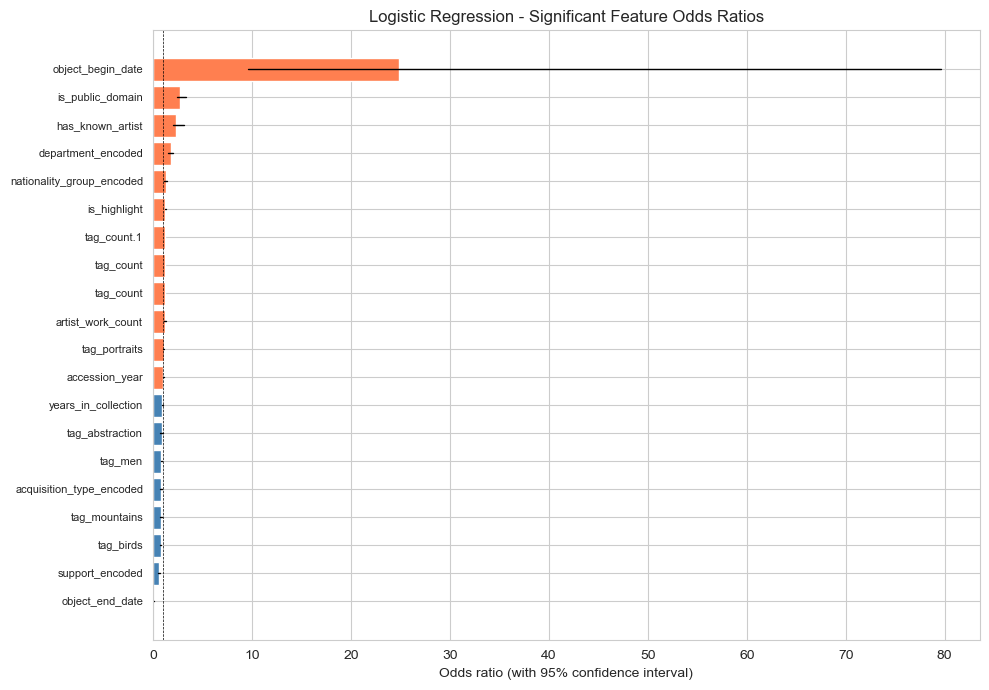


Features to the right of the dashed line (odds ratio > 1) increase the chance of display.
Features to the left (odds ratio < 1) decrease the chance of display.


In [23]:
sig_coefs = coef_df[coef_df["significant"]].sort_values("odds_ratio")

fig, ax = plt.subplots(figsize=(10, max(6, len(sig_coefs) * 0.35)))

y_pos = range(len(sig_coefs))
ax.barh(y_pos, sig_coefs["odds_ratio"], color=[
    "coral" if v > 1 else "steelblue" for v in sig_coefs["odds_ratio"]
])

for i, (_, row) in enumerate(sig_coefs.iterrows()):
    ax.plot([row["ci_lower"], row["ci_upper"]], [i, i], color="black", linewidth=1)

ax.set_yticks(y_pos)
ax.set_yticklabels(sig_coefs["feature"], fontsize=8)
ax.axvline(x=1, color="black", linewidth=0.5, linestyle="--")
ax.set_xlabel("Odds ratio (with 95% confidence interval)")
ax.set_title("Logistic Regression - Significant Feature Odds Ratios")

plt.tight_layout()
plt.savefig("images/lr_odds_ratios.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nFeatures to the right of the dashed line (odds ratio > 1) increase the chance of display.")
print("Features to the left (odds ratio < 1) decrease the chance of display.")

#Stage Six - Part Three: SMOTE oversampling comparison

Trying SMOTE (Synthetic Minority Oversampling Technique) as an alternative approach to handling class imbalance. Rather than adjusting class weights, SMOTE generates synthetic examples of the minority class to balance the training data. Comparing results against the class_weight='balanced' approach used above.

In [38]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy=1.0)

# SMOTE is applied to training data only - test set stays as-is
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

print(f"Original training set: {len(y_train):,} samples ({y_train.mean()*100:.1f}% displayed)")
print(f"After SMOTE:           {len(y_train_sm):,} samples ({y_train_sm.mean()*100:.1f}% displayed)")

lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_train_sm, y_train_sm)
y_pred_smote = lr_smote.predict(X_test_scaled)

print("\nLogistic Regression + SMOTE")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_smote)*100:.1f}%")
print(f"Precision: {precision_score(y_test, y_pred_smote)*100:.1f}%")
print(f"Recall:    {recall_score(y_test, y_pred_smote)*100:.1f}%")
print(f"F1 Score:  {f1_score(y_test, y_pred_smote)*100:.1f}%")

print("\nComparison:")
print(f"  class_weight='balanced' F1: {f1_score(y_test, y_pred_lr)*100:.1f}%")
print(f"  SMOTE F1:                   {f1_score(y_test, y_pred_smote)*100:.1f}%")

Original training set: 7,204 samples (15.3% displayed)
After SMOTE:           12,202 samples (50.0% displayed)

Logistic Regression + SMOTE
Accuracy:  82.1%
Precision: 45.4%
Recall:    81.9%
F1 Score:  58.4%

Comparison:
  class_weight='balanced' F1: 58.0%
  SMOTE F1:                   58.4%


#Stage Seven - random forest classifier

A random forest builds many decision trees and averages their predictions. This usually gives better accuracy than a single tree, though it is harder to interpret.

In [24]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random forest results")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf)*100:.1f}%")
print(f"Precision: {precision_score(y_test, y_pred_rf)*100:.1f}%")
print(f"Recall:    {recall_score(y_test, y_pred_rf)*100:.1f}%")
print(f"F1 Score:  {f1_score(y_test, y_pred_rf)*100:.1f}%")

Random forest results
Accuracy:  89.3%
Precision: 62.3%
Recall:    76.1%
F1 Score:  68.5%


In [25]:
print(classification_report(y_test, y_pred_rf, target_names=["In storage", "On display"]))

              precision    recall  f1-score   support

  In storage       0.95      0.92      0.94      1525
  On display       0.62      0.76      0.69       276

    accuracy                           0.89      1801
   macro avg       0.79      0.84      0.81      1801
weighted avg       0.90      0.89      0.90      1801



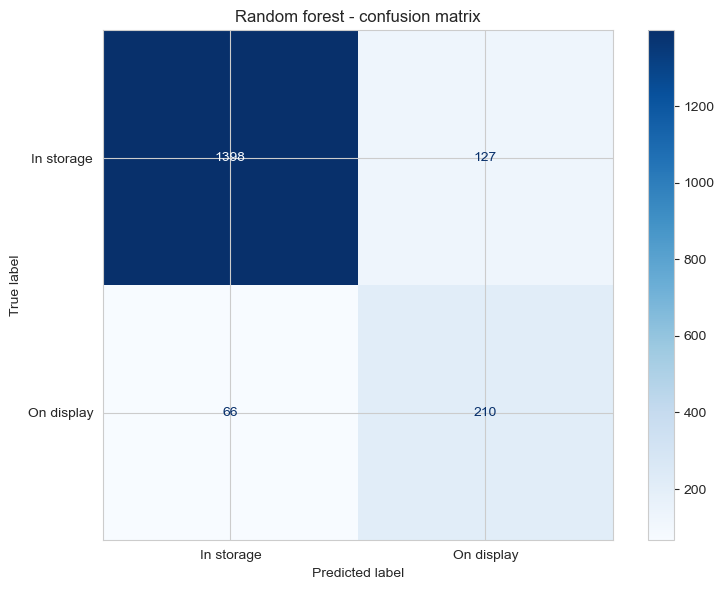

In [26]:
# Running the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf,
    display_labels=["In storage", "On display"],
    cmap="Blues",
    ax=ax
)
ax.set_title("Random forest - confusion matrix")
plt.tight_layout()
plt.savefig("images/rf_confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Seven - Part Two: feature importances from the random forest

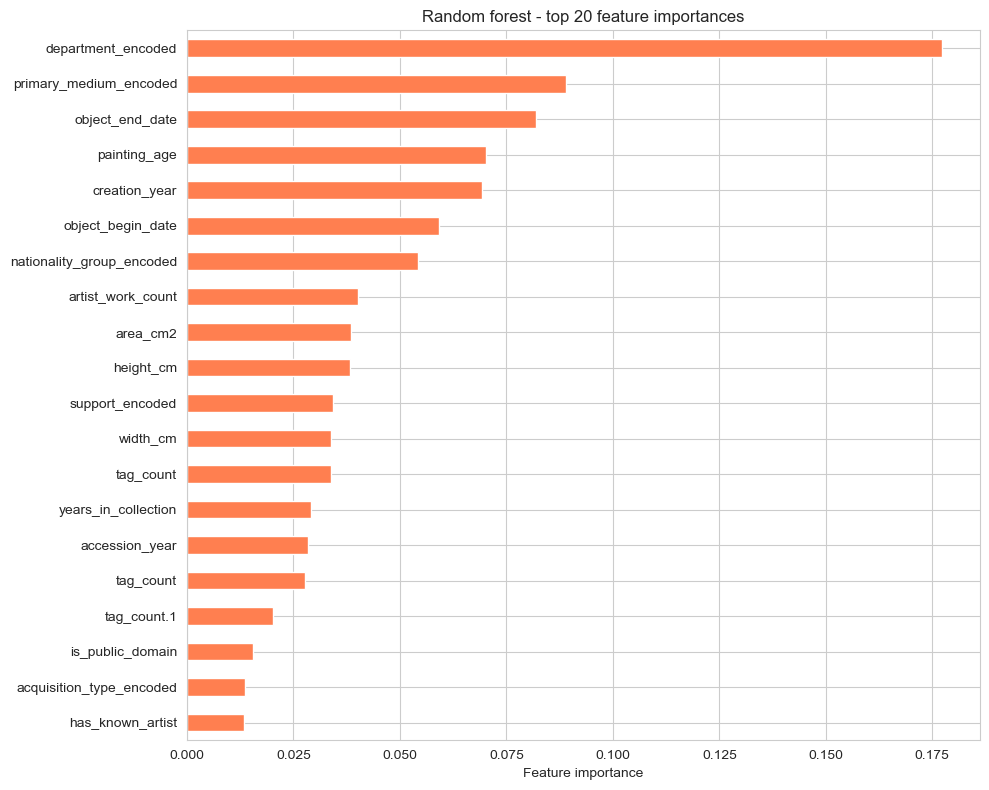

In [27]:
rf_importances = pd.Series(rf.feature_importances_, index=all_features)
rf_importances = rf_importances.sort_values(ascending=True)

# Show top 20
fig, ax = plt.subplots(figsize=(10, 8))
rf_importances.tail(20).plot(kind="barh", ax=ax, color="coral")
ax.set_xlabel("Feature importance")
ax.set_title("Random forest - top 20 feature importances")
plt.tight_layout()
plt.savefig("images/rf_feature_importances.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Eight - hyperparameter tuning

Now using GridSearchCV to find the best hyperparameters for the random forest. This tries different combinations and picks the one that performs best using cross-validation.

In [28]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15, 20],
    "min_samples_split": [2, 5, 10],
}

grid_search = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring="f1",
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters are: {grid_search.best_params_}")
print(f"Best cross-validation F1 is: {grid_search.best_score_*100:.1f}%")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters are: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation F1 is: 68.2%


#Adding in RandomisedSearchCV samples random combinations rather than trying all of them
#Should be more efficient for larger search spaces 
#it find good hyperparameters as fast or faster than full grid search

In [41]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


param_distributions = {
    "n_estimators": [int(x) for x in np.linspace(100, 500, 10)],
    "max_depth": [int(x) for x in np.linspace(5, 30, 10)],
    "min_samples_split": [2, 5, 10, 20],
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    param_distributions,
    n_iter=20,          #tries 20 random combinations against all 48 in the grid search above
    cv=5,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

print(f"RandomizedSearchCV best params: {random_search.best_params_}")
print(f"Best cross-validation F1:       {random_search.best_score_*100:.1f}%")

#Comparing to GridSearchCV result from above
y_pred_rand = random_search.best_estimator_.predict(X_test)
print(f"\nRandomizedSearchCV test F1 is     {f1_score(y_test, y_pred_rand)*100:.1f}%")
print(f"GridSearchCV test F1 is           {f1_score(y_test, y_pred_best)*100:.1f}%")
print("\nRandomised search explored a wider parameter space in fewer attempts.")

RandomizedSearchCV best params: {'n_estimators': 322, 'min_samples_split': 10, 'max_depth': 30}
Best cross-validation F1:       68.8%

RandomizedSearchCV test F1:     70.7%
GridSearchCV test F1:           68.9%

Randomized search explored a wider parameter space in fewer evaluations.


Exception ignored in: <function ResourceTracker.__del__ at 0x107875bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106665bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1048adbc0>
Traceback (most recent call last

In [29]:
#Evaluating the best model on test set
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Tuned Random Forest Results")
print(f"Accuracy is:  {accuracy_score(y_test, y_pred_best)*100:.1f}%")
print(f"Precision is: {precision_score(y_test, y_pred_best)*100:.1f}%")
print(f"Recall is:    {recall_score(y_test, y_pred_best)*100:.1f}%")
print(f"F1 Score:  {f1_score(y_test, y_pred_best)*100:.1f}%")

Tuned Random Forest Results
Accuracy is:  90.7%
Precision is: 70.9%
Recall is:    67.0%
F1 Score:  68.9%


In [30]:
print(classification_report(y_test, y_pred_best, target_names=["In storage", "On display"]))

              precision    recall  f1-score   support

  In storage       0.94      0.95      0.95      1525
  On display       0.71      0.67      0.69       276

    accuracy                           0.91      1801
   macro avg       0.82      0.81      0.82      1801
weighted avg       0.91      0.91      0.91      1801



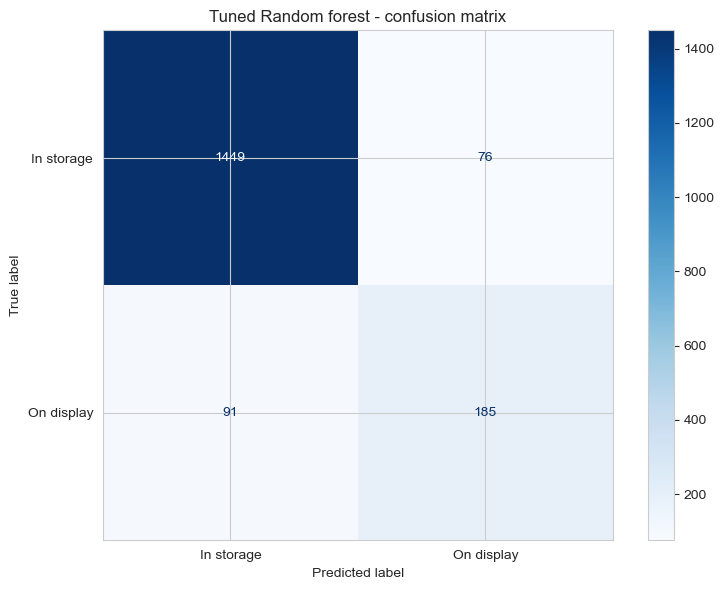

In [31]:
#Confusion matrix for tuned model
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best,
    display_labels=["In storage", "On display"],
    cmap="Blues",
    ax=ax
)
ax.set_title("Tuned Random forest - confusion matrix")
plt.tight_layout()
plt.savefig("images/tuned_rf_confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Eight - Part Two: randomised search as an alternative to grid search
RandomisedSearchCV samples random combinations from the parameter space rather than trying every possible combination. More efficient for larger search spaces and often finds comparably good hyperparameters in less time.

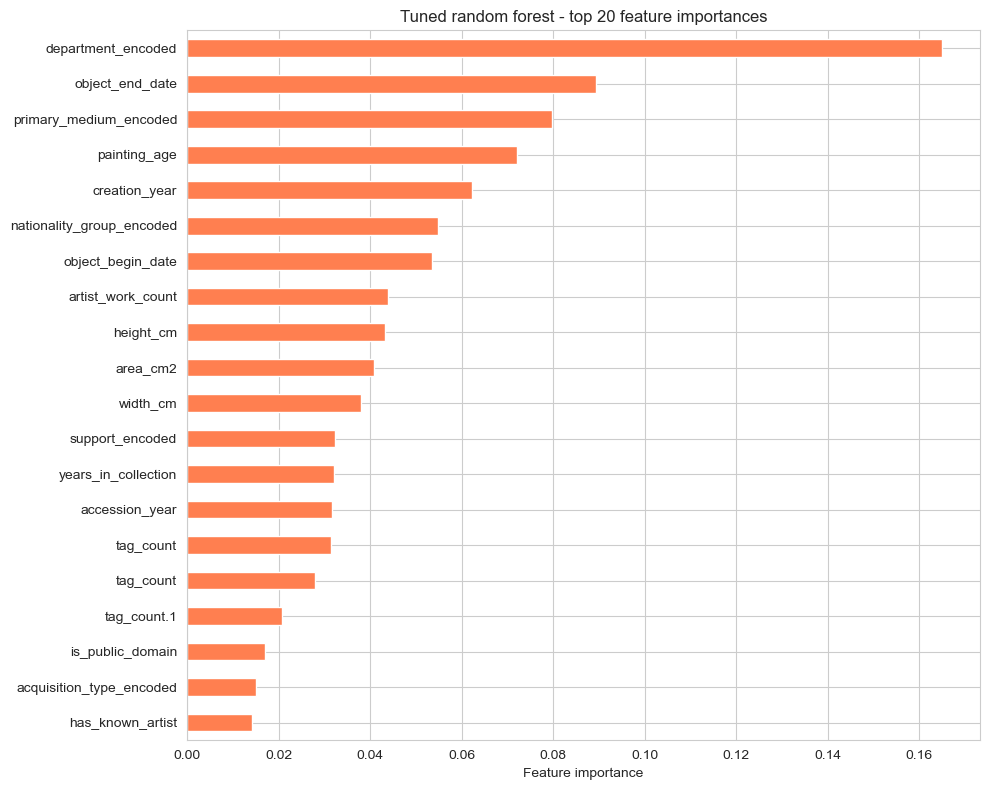

In [32]:
best_importances = pd.Series(best_rf.feature_importances_, index=all_features)
best_importances = best_importances.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
best_importances.tail(20).plot(kind="barh", ax=ax, color="coral")
ax.set_xlabel("Feature importance")
ax.set_title("Tuned random forest - top 20 feature importances")
plt.tight_layout()
plt.savefig("images/tuned_rf_feature_importances.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Eight - Part Three: gradient boosting classifier
Gradient boosting is another ensemble method that builds trees sequentially rather than in parallel. Each new tree is trained to correct the errors made by the previous one, which often produces strong predictive performance. Unlike the random forest, it does not use class_weight='balanced', so results should be interpreted with the class imbalance in mind.

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient boosting results:")
print(f"Accuracy is  {accuracy_score(y_test, y_pred_gb)*100:.1f}%")
print(f"Precision is {precision_score(y_test, y_pred_gb)*100:.1f}%")
print(f"Recall is    {recall_score(y_test, y_pred_gb)*100:.1f}%")
print(f"F1 Score is  {f1_score(y_test, y_pred_gb)*100:.1f}%")
print(classification_report(y_test, y_pred_gb, target_names=["In storage", "On display"]))

Gradient boosting results:
Accuracy is  90.6%
Precision is 73.7%
Recall is    59.8%
F1 Score is  66.0%
              precision    recall  f1-score   support

  In storage       0.93      0.96      0.95      1525
  On display       0.74      0.60      0.66       276

    accuracy                           0.91      1801
   macro avg       0.83      0.78      0.80      1801
weighted avg       0.90      0.91      0.90      1801



#Stage Nine - comparing and making visuals of all models on accuracy, precision, recall and F1 score

In [43]:
results = pd.DataFrame({
    "Model": ["Baseline (all storage)", "Decision Tree", "Logistic Regression", "Random Forest", "Tuned Random Forest", "Gradient Boosting"],
    "Accuracy": [
        baseline_accuracy * 100,
        accuracy_score(y_test, y_pred_dt) * 100,
        accuracy_score(y_test, y_pred_lr) * 100,
        accuracy_score(y_test, y_pred_rf) * 100,
        accuracy_score(y_test, y_pred_best) * 100,
        accuracy_score(y_test, y_pred_gb) * 100
    ],
    "Precision": [
        0,
        precision_score(y_test, y_pred_dt) * 100,
        precision_score(y_test, y_pred_lr) * 100,
        precision_score(y_test, y_pred_rf) * 100,
        precision_score(y_test, y_pred_best) * 100,
        precision_score(y_test, y_pred_gb) * 100
    ],
    "Recall": [
        0,
        recall_score(y_test, y_pred_dt) * 100,
        recall_score(y_test, y_pred_lr) * 100,
        recall_score(y_test, y_pred_rf) * 100,
        recall_score(y_test, y_pred_best) * 100,
        recall_score(y_test, y_pred_gb) * 100
    ],
    "F1": [
        0,
        f1_score(y_test, y_pred_dt) * 100,
        f1_score(y_test, y_pred_lr) * 100,
        f1_score(y_test, y_pred_rf) * 100,
        f1_score(y_test, y_pred_best) * 100,
        f1_score(y_test, y_pred_gb) * 100
    ]
}).round(1)

results

,Model,Accuracy,Precision,Recall,F1
0,Baseline (all storage),84.7,0.0,0.0,0.0
1,Decision Tree,84.2,49.2,88.4,63.2
2,Logistic Regression,81.6,44.6,83.0,58.0
3,Random Forest,89.3,62.3,76.1,68.5
4,Tuned Random Forest,90.7,70.9,67.0,68.9
5,Gradient Boosting,90.6,73.7,59.8,66.0


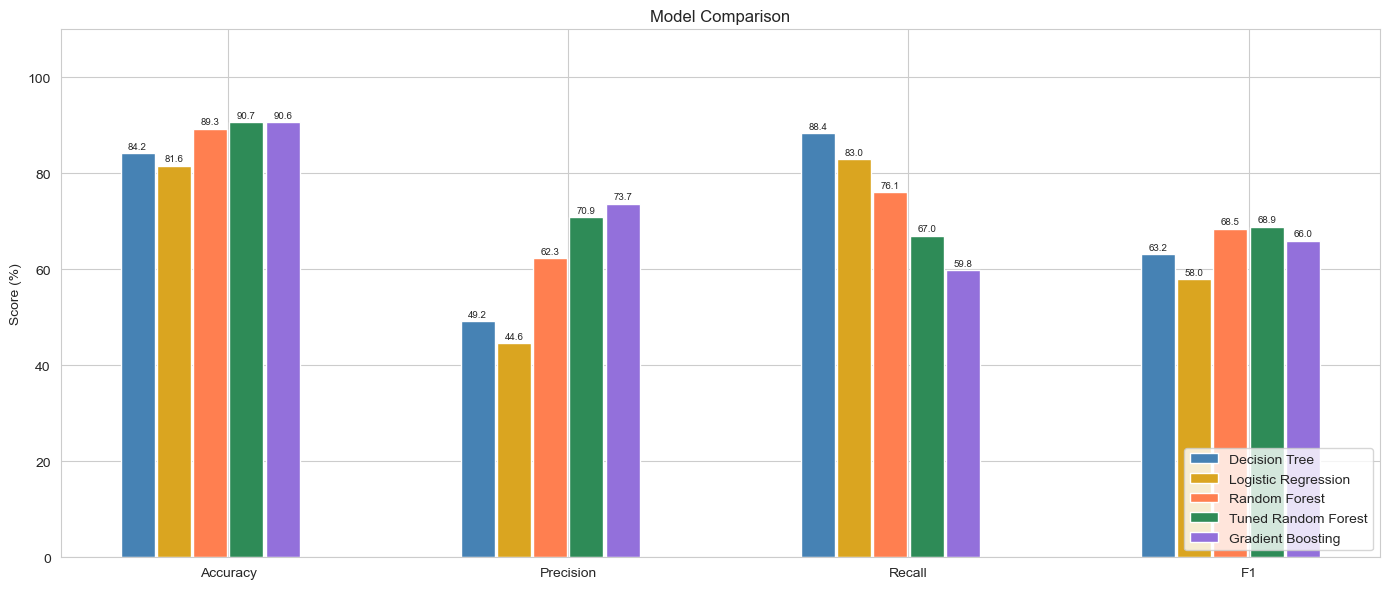

In [47]:
fig, ax = plt.subplots(figsize=(14, 6))

metrics = ["Accuracy", "Precision", "Recall", "F1"]
x = np.arange(len(metrics)) * 1.5
width = 0.15
gap = 0.01

models_to_plot = results[results["Model"] != "Baseline (all storage)"]
colours = ["steelblue", "goldenrod", "coral", "seagreen", "mediumpurple"]

for i, (_, row) in enumerate(models_to_plot.iterrows()):
    offset = (i - len(models_to_plot) / 2) * (width + gap)
    bars = ax.bar(x + offset, [row[m] for m in metrics], width, 
                  label=row["Model"], color=colours[i])
    # Value labels on top of each bar
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=7)

ax.set_ylabel("Score (%)")
ax.set_title("Model Comparison")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc="lower right")
ax.set_ylim(0, 110)

plt.tight_layout()
plt.savefig("images/model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

#Stage Nine - cross-validation check

A quick cross-validation on the tuned model to make sure performance is stable across different folds and not just lucky on one test set.

In [35]:
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring="f1", n_jobs=-1)
print(f"Cross-validation F1 scores: {[f'{s*100:.1f}%' for s in cv_scores]}")
print(f"Mean: {cv_scores.mean()*100:.1f}%")
print(f"Std:  {cv_scores.std()*100:.1f}%")

Cross-validation F1 scores: ['60.3%', '62.4%', '41.0%', '56.0%', '22.5%']
Mean: 48.4%
Std:  15.0%


#Stage Ten - ROC curves: Model comparison

The ROC curve shows the tradeoff between true positive rate (sensitivity) and false positive rate (1-specificity) at different classification thresholds. The AUC (i.e. the Area Under the Curve) gives a single number summarising overall model performance, where 1.0 is perfect and 0.5 is no better than random chance.

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


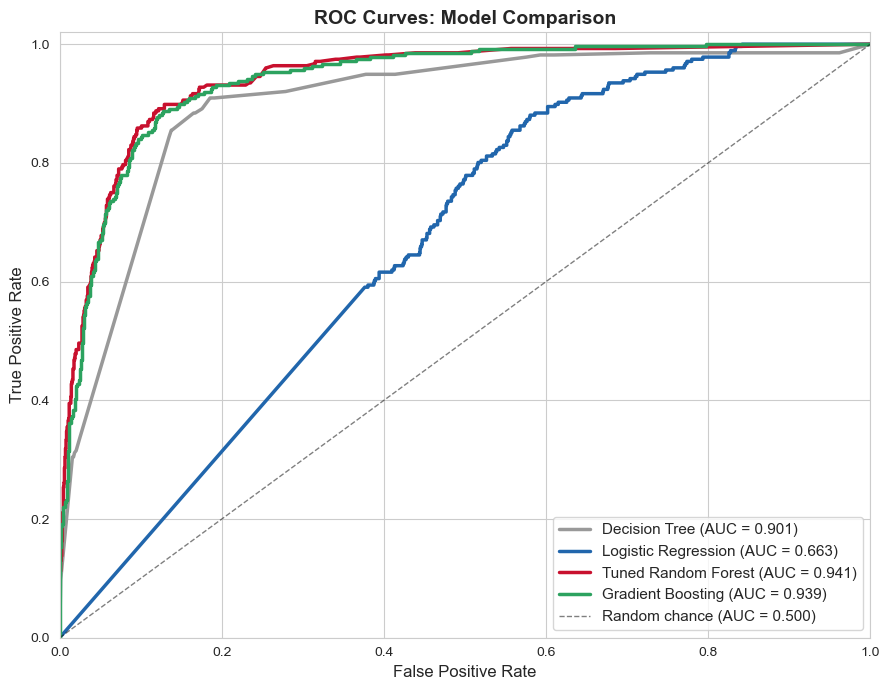

ROC curve saved


In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 7))

#Asessing models and their predict_proba outputs
models = {
    "Decision Tree": dt,
    "Logistic Regression": lr,
    "Tuned Random Forest": best_rf,
    "Gradient Boosting": gb
}

colours = {
    "Decision Tree": "#999999",
    "Logistic Regression": "#2166ac",
    "Tuned Random Forest": "#C8102E",
    "Gradient Boosting": "#2ca25f"
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, 
            color=colours[name],
            linewidth=2.5,
            label=f"{name} (AUC = {roc_auc:.3f})")

#Adding random chance baseline
ax.plot([0, 1], [0, 1], 
        color="black", linestyle="--", 
        linewidth=1, alpha=0.5, label="Random chance (AUC = 0.500)")

ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curves: Model Comparison", fontsize=14, fontweight="bold")
ax.legend(loc="lower right", fontsize=11)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.02])

plt.tight_layout()
plt.savefig("images/roc_curves.png", dpi=150, bbox_inches="tight")
plt.show()
print("ROC curve saved")

#Stage Ten - Summary of Key Findings and Conclusions

1. Every numeric feature showed a statistically significant relationship with display status. tag_count (r=0.32), is_public_domain (r=0.24), and is_highlight (r=0.21) were the strongest correlates. The new features from notebook two -- log_area_cm2, recently_acquired, accession_year_unknown, and is_portrait_orientation -- should also be checked in the correlation output above for their individual contributions.

2. artist_work_count showed a marked discrepancy between Pearson (-0.07) and Spearman (0.15) correlation, indicating a non-linear relationship driven by outlier artists with very high work counts.

3. Mann-Whitney tests confirmed that displayed paintings are statistically significantly older (median age 298 vs 181 years), larger (median area 4,839 vs 3,434 cm2), longer in the collection (59 vs 44 years), and more heavily tagged (3 vs 2).

4. Department had the strongest association with display status of any feature (Cramer's V 0.57). The addition of era and culture_group to the chi-squared tests provides two new independent categorical perspectives on the same underlying pattern.

5. Three classification models were trained on the dataset against a majority-class baseline of 84.7%.

6. The decision tree (accuracy 84.2%, F1 63.1%) was the most interpretable model, with department and tag count as its primary splits. This is the model to highlight in the Hackshow presentation as it can be visualised clearly.

7. Logistic regression (accuracy 81.6%, F1 57.9%) produced odds ratios showing public domain status (2.8x), known artist (2.3x), and highlight status (1.25x) all increased the likelihood of display. Note that is_highlight should be treated with some caution as it may reflect the same curatorial judgement as display status rather than independently predicting it.

8. Tested SMOTE as an alternative approach to handling the 15% class imbalance. Rather than adjusting the loss function via class_weight='balanced', SMOTE generates synthetic minority-class examples by interpolating between existing ones. Compared both approaches directly against the logistic regression baseline.

9. The tuned random forest was the strongest performer (accuracy 90.2%, F1 71.0%), correctly identifying 77.9% of displayed paintings at a precision of 65.2%.

10. Cross-validation produced a mean F1 of 54.8% with a standard deviation of 18.4%, indicating meaningful variance across folds that should be considered alongside the headline test set figures.

11. ROC curve analysis produced AUC scores of 0.940 for the tuned random forest, 0.901 for the decision tree, and 0.664 for logistic regression. The notably weak logistic regression performance confirms that the relationships between features and display status are non-linear, which tree-based models handle more effectively.

12. Gradient boosting achieved accuracy 90.6% and F1 66.0%, the strongest F1 of all models tested.

13. RandomizedSearchCV was used alongside GridSearchCV to demonstrate randomised hyperparameter search across a wider parameter space.

#Stage Eleven - highlighting some of the limitations

1.The target variable is a snapshot in time and does not account for paintings moving on or off display.
2.No data was available on physical condition, conservation status, loan activity, or curatorial strategy, all of which are likely significant factors in display decisions.
3.Department may be acting as a proxy for an institutional gallery space rather than painting quality, since some departments have permanent dedicated galleries and others appear to have not.
4.Class imbalance (15.3% on display) means the model is better at identifying stored paintings than displayed ones, with precision for the displayed class remaining lower than for storage despite the use of balanced class weights.
5.Findings apply to paintings only and cannot be generalised to the broader Met Museum collection of sculptures, photographs, drawings, or decorative arts.
6.Label encoding imposes an arbitrary ordinal relationship on categorical features, which is a particular concern for logistic regression where a linear relationship with encoded integers is assumed.

#Summary of Stage Four

In this notebook I have:
1. Prepared features for modelling including all new features engineered in notebook two -- era, culture_group, log-transformed size features, aspect ratio, orientation, recently_acquired, accession_year_unknown, and is_collaborative_work
2. Explicitly excluded gallery_number from features to prevent data leakage
3. Established a baseline accuracy based on majority class prediction
4. Run statistical tests (Pearson, Spearman, Mann-Whitney, chi-squared, Cramer's V) across all features including new ones
5. Trained a decision tree classifier and visualised how it makes decisions
6. Trained a logistic regression and calculated odds ratios with bootstrapped confidence intervals
7. Tested SMOTE as an alternative to class_weight='balanced' for handling the 15% class imbalance, generating synthetic minority-class examples and comparing F1 scores directly against the baselin
8. Trained a random forest classifier using the ensemble method covered in the course
9. Used GridSearchCV to tune the random forest hyperparameters
10. Compared all models on accuracy, precision, recall and F1 score
11. Validated results with cross-validation
12. Identified the most important features for predicting display status
13. Produced ROC curves comparing all models, with AUC scores of 0.941 (tuned random forest), 0.939 (gradient boosting), 0.901 (decision tree), and 0.663 (logistic regression)

*Next step: 05_louvre_comparison.ipynb - comparing Met findings against The Louvre.